In [2]:
!pip install ee

In [3]:
!pip install windows-curses

In [4]:
!pip install google-api-python-client

In [5]:
!pip install earthengine-api

  Created wheel for earthengine-api: filename=earthengine_api-0.1.292-py3-none-any.whl size=261944 sha256=614f01f03d7c5fb81fa2b0a094b07bb2265c518ba20a2c71bacde004ca8a1914
  Stored in directory: c:\users\zenudeen\appdata\local\pip\cache\wheels\2d\5f\6f\afe0075e5a5ff44ff1c20b514f8c6fabf510a3356685b043d3
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18058 sha256=44359013b75d28cd9addf79ba53101751dd7ffe5979a4105e4f336c0e155206b
  Stored in directory: c:\users\zenudeen\appdata\local\pip\cache\wheels\cc\e7\8f\8a433809ef32e27c1f24d80effef7dde1212f72fec13df73aa
Successfully built earthengine-api httplib2shim
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.3.3
    Uninstalling google-auth-2.3.3:
      Successfully uninstalled google-auth-2.3.3
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.3.0
    Uninstalling google-api-core-2.3.0:
      Successfully uninstalled google-api-co

In [10]:
# Imports

import pandas as pd
import ee
from tqdm import tqdm # Progress bar
from datetime import timedelta
import datetime

In [2]:
ee.Authenticate()  # Run once to link your Google Earth Engine account

Enter verification code: 4/1AX4XfWhAT2G5Aa09-FRrG_QBz_BEPWudrQL7EXD86mU0wtzTPRGDIctrSLQ

Successfully saved authorization token.


In [11]:
ee.Initialize() # Run each session

In [12]:
world = pd.read_csv('UNITEDKINGDOMPM25.csv')

In [13]:
# Renaming columns to make clearer

try:
    world = world.rename(columns={"date.utc": "Date", "coordinates.latitude": "Lat", "coordinates.longitude":"Long", "value": "PM25"})
    world['Date'] = world['Date'].astype(str).str[:10]
    world = world.drop(columns=['unit', 'parameter'], axis =1)
    world = world[['location', 'Date', 'city', 'country', 'PM25', 'Lat','Long']]
    world['PM25'] = world.groupby(['Date','location'])['PM25'].transform(lambda x: x.mean())
    world = world.groupby(['Date', 'location']).first().reset_index()
except:
    print('Already done')

Already done


In [14]:
world.head()

,Unnamed: 0,Date,location,city,country,PM25,Lat,Long
0,0,2018-11-22,Aberdeen,Aberdeen,GB,11.739130,57.157360,-2.094278
1,1,2018-11-22,Aberdeen-Division St,Aberdeen,US,7.627273,46.977200,-123.831700
2,2,2018-11-22,Auchencorth Moss,Auchencorth,GB,10.125000,55.792160,-3.242900
3,3,2018-11-22,Barnstaple A39,Barnstaple,GB,16.333333,51.074793,-4.041924
4,4,2018-11-22,Belfast Centre,Belfast,GB,14.958333,54.599650,-5.928833


In [6]:
# A utility function to pull data for a set of locations
def sample(im, prop, lats, lons, scale=100, reducer=ee.Reducer.first(), tileScale=4):
    points = []
    for lat, lon in zip(lats, lons):
        xy = ee.Geometry.Point([lon, lat])
        points.append(xy.buffer(scale))
    vals = im.reduceRegions(collection=ee.FeatureCollection(points), scale=scale, reducer=reducer, tileScale=tileScale).getInfo()
    if prop == '':
        return [v['properties'] for v in vals['features']]
    return [v['properties'][prop] for v in vals['features']]

In [7]:
#population data
def add_static_vars(df, scale = 2000):
    lights = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    pop = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    ims = [lights, pop]

    for im in tqdm(ims):
        for i, reducer in enumerate([ee.Reducer.mean(), ee.Reducer.min(), ee.Reducer.max()]):
            sampled_values = sample(im, '', df['Lat'].values, df['Long'].values, reducer=reducer)
            for k in sampled_values[0].keys():
                arr = ['mean', 'min', 'max']
                df[k+'_'+ arr[i]] = [sv[k] if k in sv.keys() else None for sv in sampled_values]
                if k == arr[i]:
                    df = df.rename(columns={k+'_'+ arr[i]:'pop_density2010'+'_'+ arr[i]})
    return df

In [8]:
locations = world.groupby('location').first().reset_index() # The locations to query
locations

,location,Unnamed: 0,Date,city,country,PM25,Lat,Long
0,Aberdeen,0,2018-11-22,Aberdeen,GB,11.739130,57.157360,-2.094278
1,Aberdeen-Division St,1,2018-11-22,Aberdeen,US,7.627273,46.977200,-123.831700
2,Auchencorth Moss,2,2018-11-22,Auchencorth,GB,10.125000,55.792160,-3.242900
3,Barnstaple A39,3,2018-11-22,Barnstaple,GB,16.333333,51.074793,-4.041924
4,Belfast Centre,4,2018-11-22,Belfast,GB,14.958333,54.599650,-5.928833
...,...,...,...,...,...,...,...,...
75,Wirral Tranmere,56,2018-11-22,Liverpool,GB,22.625000,53.372870,-3.022722
76,Worthing A27 Roadside,57,2018-11-22,South East,GB,24.000000,50.832947,-0.379916
77,Wrexham,58,2018-11-22,Wrexham,GB,25.521739,53.042220,-3.002778
78,York Bootham,59,2018-11-22,York,GB,24.434783,53.967513,-1.086514


In [9]:
# Add static vars
locations_w_static = add_static_vars(locations.copy())
locations_w_static

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


,location,Unnamed: 0,Date,city,country,PM25,Lat,Long,avg_vis_mean,cf_cvg_mean,avg_vis_min,cf_cvg_min,avg_vis_max,cf_cvg_max,pop_density2010_mean,pop_density2010_min,pop_density2010_max
0,Aberdeen,0,2018-11-22,Aberdeen,GB,11.739130,57.157360,-2.094278,334.982815,13.0,332.663116,13,332.663116,13,8788.521484,8788.521484,8788.521484
1,Aberdeen-Division St,1,2018-11-22,Aberdeen,US,7.627273,46.977200,-123.831700,54.241188,9.0,54.241188,9,54.241188,9,1927.006348,1927.006348,1927.006348
2,Auchencorth Moss,2,2018-11-22,Auchencorth,GB,10.125000,55.792160,-3.242900,12.667045,48.0,12.667045,48,12.667045,48,7.703879,7.703878,7.703879
3,Barnstaple A39,3,2018-11-22,Barnstaple,GB,16.333333,51.074793,-4.041924,37.478218,62.0,37.478218,62,37.478218,62,3878.105249,3026.625244,4439.924805
4,Belfast Centre,4,2018-11-22,Belfast,GB,14.958333,54.599650,-5.928833,288.115729,15.0,284.262726,15,289.223877,15,2318.533691,2303.730713,2303.730713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Wirral Tranmere,56,2018-11-22,Liverpool,GB,22.625000,53.372870,-3.022722,128.883560,9.0,128.883560,9,128.883560,9,5830.232422,5830.232422,5830.232422
76,Worthing A27 Roadside,57,2018-11-22,South East,GB,24.000000,50.832947,-0.379916,102.193448,10.0,102.387161,10,102.387161,10,3768.843227,4320.272461,4320.272461
77,Wrexham,58,2018-11-22,Wrexham,GB,25.521739,53.042220,-3.002778,26.041843,11.0,26.041843,11,26.041843,11,2854.658698,2880.051514,2880.051514
78,York Bootham,59,2018-11-22,York,GB,24.434783,53.967513,-1.086514,173.781859,6.0,172.903290,6,172.903290,6,7206.880064,7372.168945,7372.168945


In [10]:
try:
    locations_w_static = locations_w_static.drop(columns=['Date', 'PM25', 'Lat', 'Long', 'city','country'], axis=1)
except:
    pass

In [11]:
world_w_static = pd.merge(world, locations_w_static, on='location')

In [12]:
world_w_static = world_w_static.rename(columns = {'Date_x':'Date'})

In [32]:
# Add vegetation index
def add_static_vars2(df, scale = 8000):
    vegs = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5").filter(ee.Filter.date('2018-11-22', '2021-05-07')).first()
    veg_list = [vegs]

    for veg in tqdm(veg_list):
        for i, reducer in enumerate([ee.Reducer.mean(), ee.Reducer.min(), ee.Reducer.max()]):
            sampled_values = sample(veg, '', df['Lat'].values, df['Long'].values, reducer=reducer, scale=scale)
            for k in sampled_values[0].keys():
                arr = ['mean', 'min', 'max']
                df[k+'_'+str(scale)+'_' + arr[i]] = [sv[k] if k in sv.keys() else None for sv in sampled_values]
                if k == arr[i]:
                    df = df.rename(columns={k+'_'+str(scale)+'_' + arr[i]:'veg_index'+'_'+str(scale)+'_' + arr[i]})
    return df

In [33]:
# Add static vars
locations_w_veg = add_static_vars2(locations.copy())
locations_w_veg

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


,location,Unnamed: 0,Date,city,country,PM25,Lat,Long,NDVI_8000_mean,QA_8000_mean,TIMEOFDAY_8000_mean,NDVI_8000_min,QA_8000_min,TIMEOFDAY_8000_min,NDVI_8000_max,QA_8000_max,TIMEOFDAY_8000_max
0,Aberdeen,0,2018-11-22,Aberdeen,GB,11.739130,57.157360,-2.094278,NaN,8000.000000,NaN,NaN,8000,NaN,NaN,8000,NaN
1,Aberdeen-Division St,1,2018-11-22,Aberdeen,US,7.627273,46.977200,-123.831700,0.0,12349.320690,2364.0,0.0,8000,2364.0,0.0,24706,2364.0
2,Auchencorth Moss,2,2018-11-22,Auchencorth,GB,10.125000,55.792160,-3.242900,NaN,8000.000000,NaN,NaN,8000,NaN,NaN,8000,NaN
3,Barnstaple A39,3,2018-11-22,Barnstaple,GB,16.333333,51.074793,-4.041924,NaN,17326.047356,1516.0,NaN,16770,1516.0,NaN,16770,1516.0
4,Belfast Centre,4,2018-11-22,Belfast,GB,14.958333,54.599650,-5.928833,NaN,8000.000000,NaN,NaN,8000,NaN,NaN,8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Wirral Tranmere,56,2018-11-22,Liverpool,GB,22.625000,53.372870,-3.022722,NaN,13520.259819,1517.0,NaN,8000,1517.0,NaN,24962,1517.0
76,Worthing A27 Roadside,57,2018-11-22,South East,GB,24.000000,50.832947,-0.379916,0.0,-8149.833861,1516.0,NaN,-24438,NaN,NaN,8000,NaN
77,Wrexham,58,2018-11-22,Wrexham,GB,25.521739,53.042220,-3.002778,-433.5,15327.619048,1517.0,-867.0,8000,1517.0,0.0,24706,1517.0
78,York Bootham,59,2018-11-22,York,GB,24.434783,53.967513,-1.086514,NaN,8000.000000,NaN,NaN,8000,NaN,NaN,8000,NaN


In [15]:
locations_w_veg = locations_w_veg.drop(columns=['Date', 'PM25', 'Lat', 'Long', 'city','country'], axis=1)
world_w_veg = pd.merge(world, locations_w_veg, on='location')

In [24]:
world_w_veg

,Unnamed: 0_x,Date,location,city,country,PM25,Lat,Long,Unnamed: 0_y,NDVI_8000_mean,QA_8000_mean,TIMEOFDAY_8000_mean,NDVI_8000_min,QA_8000_min,TIMEOFDAY_8000_min,NDVI_8000_max,QA_8000_max,TIMEOFDAY_8000_max
0,0,2018-11-22,Aberdeen,Aberdeen,GB,11.739130,57.157360,-2.094278,0,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
1,61,2018-11-23,Aberdeen,Aberdeen,GB,5.086957,57.157360,-2.094278,0,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
2,123,2018-11-24,Aberdeen,Aberdeen,GB,4.304348,57.157360,-2.094278,0,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
3,185,2018-11-25,Aberdeen,Aberdeen,GB,4.000000,57.157360,-2.094278,0,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
4,245,2018-11-26,Aberdeen,Aberdeen,GB,3.347826,57.157360,-2.094278,0,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62387,62083,2021-05-03,Southwark A2 Old Kent Road,London,GB,6.857895,51.480499,-0.059550,61856,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
62388,62153,2021-05-04,Southwark A2 Old Kent Road,London,GB,3.050000,51.480499,-0.059550,61856,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
62389,62227,2021-05-05,Southwark A2 Old Kent Road,London,GB,3.390909,51.480499,-0.059550,61856,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN
62390,62303,2021-05-06,Southwark A2 Old Kent Road,London,GB,5.176190,51.480499,-0.059550,61856,NaN,8000.0,NaN,NaN,8000,NaN,NaN,8000,NaN


In [16]:
def add_static_vars3(df, scale = 2000):
    elevations = ee.Image('USGS/GMTED2010').select('be75')
    elevation_list = [elevations]

    for elevation in tqdm(elevation_list):
        for i, reducer in enumerate([ee.Reducer.mean(), ee.Reducer.min(), ee.Reducer.max()]):
            sampled_values = sample(elevation, '', df['Lat'].values, df['Long'].values, reducer=reducer, scale=scale)
            for k in sampled_values[0].keys():
                arr = ['mean', 'min', 'max']
                df[k+'_'+str(scale)+'_' + arr[i]] = [sv[k] if k in sv.keys() else None for sv in sampled_values]
                if k == arr[i]:
                    df = df.rename(columns={k+'_'+str(scale)+'_' + arr[i]:'elevation'+'_'+str(scale)+'_' + arr[i]})
    return df

In [18]:
locations_w_elevation = add_static_vars3(locations.copy())
locations_w_elevation

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


,location,Unnamed: 0,Date,city,country,PM25,Lat,Long,elevation_2000_mean,elevation_2000_min,elevation_2000_max
0,Aberdeen,0,2018-11-22,Aberdeen,GB,11.739130,57.157360,-2.094278,21.609085,5,31
1,Aberdeen-Division St,1,2018-11-22,Aberdeen,US,7.627273,46.977200,-123.831700,19.976623,3,23
2,Auchencorth Moss,2,2018-11-22,Auchencorth,GB,10.125000,55.792160,-3.242900,255.626686,230,273
3,Barnstaple A39,3,2018-11-22,Barnstaple,GB,16.333333,51.074793,-4.041924,46.053755,13,50
4,Belfast Centre,4,2018-11-22,Belfast,GB,14.958333,54.599650,-5.928833,14.878744,8,26
...,...,...,...,...,...,...,...,...,...,...,...
75,Wirral Tranmere,56,2018-11-22,Liverpool,GB,22.625000,53.372870,-3.022722,36.274046,16,55
76,Worthing A27 Roadside,57,2018-11-22,South East,GB,24.000000,50.832947,-0.379916,26.852538,5,51
77,Wrexham,58,2018-11-22,Wrexham,GB,25.521739,53.042220,-3.002778,94.634091,87,114
78,York Bootham,59,2018-11-22,York,GB,24.434783,53.967513,-1.086514,15.889630,14,17


In [19]:
locations_w_elevation = locations_w_elevation.drop(columns=['Date', 'PM25', 'Lat', 'Long', 'city','country'], axis=1)
world_w_elevation = pd.merge(world, locations_w_elevation, on='location')
world_w_elevation

,Unnamed: 0_x,Date,location,city,country,PM25,Lat,Long,Unnamed: 0_y,elevation_2000_mean,elevation_2000_min,elevation_2000_max
0,0,2018-11-22,Aberdeen,Aberdeen,GB,11.739130,57.157360,-2.094278,0,21.609085,5,31
1,61,2018-11-23,Aberdeen,Aberdeen,GB,5.086957,57.157360,-2.094278,0,21.609085,5,31
2,123,2018-11-24,Aberdeen,Aberdeen,GB,4.304348,57.157360,-2.094278,0,21.609085,5,31
3,185,2018-11-25,Aberdeen,Aberdeen,GB,4.000000,57.157360,-2.094278,0,21.609085,5,31
4,245,2018-11-26,Aberdeen,Aberdeen,GB,3.347826,57.157360,-2.094278,0,21.609085,5,31
...,...,...,...,...,...,...,...,...,...,...,...,...
62387,62083,2021-05-03,Southwark A2 Old Kent Road,London,GB,6.857895,51.480499,-0.059550,61856,9.902191,6,19
62388,62153,2021-05-04,Southwark A2 Old Kent Road,London,GB,3.050000,51.480499,-0.059550,61856,9.902191,6,19
62389,62227,2021-05-05,Southwark A2 Old Kent Road,London,GB,3.390909,51.480499,-0.059550,61856,9.902191,6,19
62390,62303,2021-05-06,Southwark A2 Old Kent Road,London,GB,5.176190,51.480499,-0.059550,61856,9.902191,6,19


In [8]:
#timeseries data
# Image Collections
gfs = ee.ImageCollection("NOAA/GFS0P25") # Weather data

S5p_collections = {} # Sentinel 5p data, which comes in multiple collections
for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_AER_AI']: # 
    S5p_collections[COL] = ee.ImageCollection('COPERNICUS/S5P/OFFL/'+COL).map(lambda image: image.addBands\
                                                                              (image.metadata('system:time_start')))
# Properties for each image we want to keep
s5p_props = {
    'L3_NO2':['NO2_column_number_density', 'tropospheric_NO2_column_number_density', 'stratospheric_NO2_column_number_density',\
              'NO2_slant_column_number_density', 'tropopause_pressure'],
    'L3_O3':['O3_column_number_density'],
    'L3_CO':['CO_column_number_density', 'H2O_column_number_density', 'cloud_height'],
    'L3_AER_AI':['absorbing_aerosol_index']
}

def add_timeseries(df, dates, reducer=ee.Reducer.first()):
    # Prepare dataframe with date x city
    date_col = []
    location_col = []
    for d in dates:
        for c in df.location.unique():
            date_col.append(d)
            location_col.append(c)

    data = pd.DataFrame({
        'Date':date_col,
        'location':location_col
    })
    data = pd.merge(data, df[['location', 'Lat', 'Long']], how='left', on='location')
    
    for d in tqdm(dates):
        # Weather is easy - a single image from the right date
        weather_image = gfs.filter(ee.Filter.date(str(d.date()), str((d+timedelta(days=1)).date()))).first() # Filter to get the relevant image
        # For the sentinel data, we get images from each collection and merge them
        s5p_images = []
        for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_AER_AI']:
            collection = S5p_collections[COL].filter(ee.Filter.date(str((d-timedelta(days=5)).date()), str(d.date())))
            image = collection.qualityMosaic('system:time_start') # The most recent image
            image = image.select(s5p_props[COL])
            s5p_images.append(image)
        s5p_image = ee.ImageCollection(s5p_images).toBands() # Merge into one image
    
        # Sample the weather data
        samples = sample(weather_image, '', df['Lat'].values, df['Long'].values, reducer=reducer)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]
            
        # Sample the sentinel data
        samples = sample(s5p_image, '', df['Lat'].values, df['Long'].values)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]
            
    return data

In [108]:
#timeseries data
# Image Collections
gfs = ee.ImageCollection("NOAA/GFS0P25") # Weather data

s5p_collections = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').select('SO2_column_number_density').map(lambda image: image.addBands\
                                                                              (image.metadata('system:time_start')))
# Properties for each image we want to keep
s5p_props = {
    'L3_SO2':['SO2_column_number_density']
}

def add_timeseries(df, dates, reducer=ee.Reducer.first()):
    # Prepare dataframe with date x city
    date_col = []
    location_col = []
    for d in dates:
        for c in df.location.unique():
            date_col.append(d)
            location_col.append(c)

    data = pd.DataFrame({
        'Date':date_col,
        'location':location_col
    })
    data = pd.merge(data, df[['location', 'Lat', 'Long']], how='left', on='location')
    
    for d in tqdm(dates):
        # Weather is easy - a single image from the right date
        weather_image = gfs.filter(ee.Filter.date(str(d.date()), str((d+timedelta(days=1)).date()))).first() # Filter to get the relevant image
        # For the sentinel data, we get images from each collection and merge them
        s5p_images = []
        for COL in ['L3_SO2']:
            collection = S5p_collections[COL].filter(ee.Filter.date(str((d-timedelta(days=5)).date()), str(d.date())))
            image = collection.qualityMosaic('system:time_start') # The most recent image
            image = image.select(s5p_props[COL])
            s5p_images.append(image)
        s5p_image = ee.ImageCollection(s5p_images).toBands() # Merge into one image
    

        # Sample the sentinel data
        samples = sample(s5p_image, '', df['Lat'].values, df['Long'].values)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]
            
    return data

In [104]:
#weather data is until 2020-11-30
dates_2018 = pd.date_range('2018-11-22', '2018-12-31', freq='1D')
dates_2019 = pd.date_range('2019-01-01', '2019-12-31', freq='1D')
dates_2020 = pd.date_range('2020-01-01', '2020-12-31', freq='1D')
dates_2021 = pd.date_range('2021-01-01', '2021-05-07', freq='1D')

In [105]:
# 2018
world_1 = world.iloc[:2299]

# 2019
# 2019 = world.iloc[2299:26642]
world_2 = world.iloc[2299:7299]
world_3 = world.iloc[7299:12299]
world_4 = world.iloc[12299:17299]
world_5 = world.iloc[17299:22299]
world_6 = world.iloc[22299:26642]

# 2020
# 2020 = world.iloc[26642:53449]
world_7 = world.iloc[26642:31642]
world_8 = world.iloc[31642:36642]
world_9 = world.iloc[36642:41642]
world_10 = world.iloc[41642:46642]
world_11 = world.iloc[46642:51642]
world_12 = world.iloc[51642:53449]

# 2021
world_13 = world.iloc[53449:58449]
world_14 = world.iloc[58449:]

In [11]:
ts_uk1 = add_timeseries(world_1.copy(), dates_2018)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [07:40<00:00, 11.51s/it]


In [12]:
ts_uk2 = add_timeseries(world_2.copy(), dates_2019)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [1:27:39<00:00, 14.41s/it]


In [13]:
ts_uk3 = add_timeseries(world_3.copy(), dates_2019)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [1:23:00<00:00, 13.64s/it]


In [14]:
ts_uk4 = add_timeseries(world_4.copy(), dates_2019)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [1:06:20<00:00, 10.91s/it]


In [15]:
ts_uk5 = add_timeseries(world_5.copy(), dates_2019)

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [55:54<00:00,  9.19s/it]


In [16]:
ts_uk6 = add_timeseries(world_6.copy(), dates_2019)

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [49:45<00:00,  8.18s/it]


In [17]:
ts_uk7 = add_timeseries(world_7.copy(), dates_2020)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [1:37:09<00:00, 15.93s/it]


In [18]:
ts_uk8 = add_timeseries(world_8.copy(), dates_2020)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [1:39:43<00:00, 16.35s/it]


In [19]:
ts_uk9 = add_timeseries(world_9.copy(), dates_2020)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [1:15:45<00:00, 12.42s/it]


In [20]:
ts_uk10 = add_timeseries(world_10.copy(), dates_2020)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [1:02:11<00:00, 10.20s/it]


In [33]:
ts_uk11 = add_timeseries(world_11.copy(), dates_2020)

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [1:02:00<00:00, 10.17s/it]


In [34]:
ts_uk12 = add_timeseries(world_12.copy(), dates_2020)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [32:11<00:00,  5.28s/it]


In [35]:
ts_uk13 = add_timeseries(world_13.copy(), dates_2021)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [32:25<00:00, 15.32s/it]


In [36]:
ts_uk14 = add_timeseries(world_14.copy(), dates_2021)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [28:04<00:00, 13.26s/it]


In [23]:
ts_uk1.to_csv('ts_uk1.csv')

In [24]:
ts_uk2.to_csv('ts_uk2.csv')

In [25]:
ts_uk3.to_csv('ts_uk3.csv')

In [26]:
ts_uk4.to_csv('ts_uk4.csv')

In [27]:
ts_uk5.to_csv('ts_uk5.csv')

In [28]:
ts_uk6.to_csv('ts_uk6.csv')

In [29]:
ts_uk7.to_csv('ts_uk7.csv')

In [30]:
ts_uk8.to_csv('ts_uk8.csv')

In [31]:
ts_uk9.to_csv('ts_uk9.csv')

In [37]:
ts_uk10.to_csv('ts_uk10.csv')

In [38]:
ts_uk11.to_csv('ts_uk11.csv')

In [39]:
ts_uk12.to_csv('ts_uk12.csv')

In [40]:
ts_uk13.to_csv('ts_uk13.csv')

In [41]:
ts_uk14.to_csv('ts_uk14.csv')

In [47]:
ts_uk1 = pd.read_csv('ts_uk1.csv')
ts_uk1_groupby = ts_uk1.groupby(['Date', 'location']).mean()
ts_uk1_groupby.to_csv('ts1_uk_groupby.csv')
ts_uk1_groupby.shape

(2560, 19)

In [50]:
ts_uk2 = pd.read_csv('ts_uk2.csv')
ts_uk2_groupby = ts_uk2.groupby(['Date', 'location']).mean()
ts_uk2_groupby.to_csv('ts2_uk_groupby.csv')
ts_uk2_groupby.shape

(24820, 19)

In [51]:
ts_uk3 = pd.read_csv('ts_uk3.csv')
ts_uk3_groupby = ts_uk3.groupby(['Date', 'location']).mean()
ts_uk3_groupby.to_csv('ts3_uk_groupby.csv')
ts_uk3_groupby.shape

(25185, 19)

In [52]:
ts_uk4 = pd.read_csv('ts_uk4.csv')
ts_uk4_groupby = ts_uk4.groupby(['Date', 'location']).mean()
ts_uk4_groupby.to_csv('ts4_uk_groupby.csv')
ts_uk4_groupby.shape

(25185, 19)

In [53]:
ts_uk5 = pd.read_csv('ts_uk5.csv')
ts_uk5_groupby = ts_uk5.groupby(['Date', 'location']).mean()
ts_uk5_groupby.to_csv('ts5_uk_groupby.csv')
ts_uk5_groupby.shape

(28105, 19)

In [54]:
ts_uk6 = pd.read_csv('ts_uk6.csv')
ts_uk6_groupby = ts_uk6.groupby(['Date', 'location']).mean()
ts_uk6_groupby.to_csv('ts6_uk_groupby.csv')
ts_uk6_groupby.shape

(28105, 19)

In [55]:
ts_uk7 = pd.read_csv('ts_uk7.csv')
ts_uk7_groupby = ts_uk7.groupby(['Date', 'location']).mean()
ts_uk7_groupby.to_csv('ts7_uk_groupby.csv')
ts_uk7_groupby.shape

(28548, 19)

In [56]:
ts_uk8 = pd.read_csv('ts_uk8.csv')
ts_uk8_groupby = ts_uk8.groupby(['Date', 'location']).mean()
ts_uk8_groupby.to_csv('ts8_uk_groupby.csv')
ts_uk8_groupby.shape

(28182, 19)

In [57]:
ts_uk9 = pd.read_csv('ts_uk9.csv')
ts_uk9_groupby = ts_uk9.groupby(['Date', 'location']).mean()
ts_uk9_groupby.to_csv('ts9_uk_groupby.csv')
ts_uk9_groupby.shape

(28182, 19)

In [58]:
ts_uk10 = pd.read_csv('ts_uk10.csv')
ts_uk10_groupby = ts_uk10.groupby(['Date', 'location']).mean()
ts_uk10_groupby.to_csv('ts10_uk_groupby.csv')
ts_uk10_groupby.shape

(28182, 19)

In [59]:
ts_uk11 = pd.read_csv('ts_uk11.csv')
ts_uk11_groupby = ts_uk11.groupby(['Date', 'location']).mean()
ts_uk11_groupby.to_csv('ts11_uk_groupby.csv')
ts_uk11_groupby.shape

(27816, 19)

In [60]:
ts_uk12 = pd.read_csv('ts_uk12.csv')
ts_uk12_groupby = ts_uk12.groupby(['Date', 'location']).mean()
ts_uk12_groupby.to_csv('ts12_uk_groupby.csv')
ts_uk12_groupby.shape

(27816, 19)

In [61]:
ts_uk13 = pd.read_csv('ts_uk13.csv')
ts_uk13_groupby = ts_uk13.groupby(['Date', 'location']).mean()
ts_uk13_groupby.to_csv('ts13_uk_groupby.csv')
ts_uk13_groupby.shape

(9652, 19)

In [62]:
ts_uk14 = pd.read_csv('ts_uk14.csv')
ts_uk14_groupby = ts_uk14.groupby(['Date', 'location']).mean()
ts_uk14_groupby.to_csv('ts14_uk_groupby.csv')
ts_uk14_groupby.shape

(9906, 19)

In [64]:
ts1_data = pd.read_csv('ts1_uk_groupby.csv')
ts2_data = pd.read_csv('ts2_uk_groupby.csv')
ts3_data = pd.read_csv('ts3_uk_groupby.csv')
ts4_data = pd.read_csv('ts4_uk_groupby.csv')
ts5_data = pd.read_csv('ts5_uk_groupby.csv')
ts6_data = pd.read_csv('ts6_uk_groupby.csv')
ts7_data = pd.read_csv('ts7_uk_groupby.csv')
ts8_data = pd.read_csv('ts8_uk_groupby.csv')
ts9_data = pd.read_csv('ts9_uk_groupby.csv')
ts10_data = pd.read_csv('ts10_uk_groupby.csv')
ts11_data = pd.read_csv('ts11_uk_groupby.csv')
ts12_data = pd.read_csv('ts12_uk_groupby.csv')
ts13_data = pd.read_csv('ts13_uk_groupby.csv')
ts14_data = pd.read_csv('ts14_uk_groupby.csv')

In [66]:
group = [ts1_data,ts2_data,ts3_data,ts4_data,ts5_data,ts6_data,ts7_data,ts8_data,ts9_data,ts10_data,ts11_data,ts12_data,ts13_data,ts14_data]
group_timeseries = pd.concat(group)
group_timeseries.to_csv('group_timeseries.csv', index=False)

In [20]:
grouped = pd.read_csv('group_timeseries.csv')

In [21]:
grouped.columns 

Index(['Date', 'location', 'Unnamed: 0', 'Lat', 'Long',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground', '0_NO2_column_number_density',
       '0_NO2_slant_column_number_density',
       '0_stratospheric_NO2_column_number_density', '0_tropopause_pressure',
       '0_tropospheric_NO2_column_number_density',
       '1_O3_column_number_density', '2_CO_column_number_density',
       '2_H2O_column_number_density', '2_cloud_height',
       '3_absorbing_aerosol_index'],
      dtype='object')

In [23]:
world_w_static.columns

Index(['Unnamed: 0_x', 'Date', 'location', 'city', 'country', 'PM25', 'Lat',
       'Long', 'Unnamed: 0_y', 'avg_vis_mean', 'cf_cvg_mean', 'avg_vis_min',
       'cf_cvg_min', 'avg_vis_max', 'cf_cvg_max', 'pop_density2010_mean',
       'pop_density2010_min', 'pop_density2010_max'],
      dtype='object')

In [45]:
veg_elev = pd.merge(world_w_veg, world_w_elevation, on = ['location', 'Date', 'Lat', 'Long'])

In [54]:
veg_elev_pop = pd.merge(veg_elev, world_w_static, on = ['location', 'Date'])

In [55]:
veg_elev_pop_sat = pd.merge(veg_elev_pop, grouped, on = ['location', 'Date'])

C:\Users\Zenudeen\AppData\Local\Temp/ipykernel_3888/2146659294.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Lat_x', 'Long_x'} in the result is deprecated and will raise a MergeError in a future version.
  veg_elev_pop_sat = pd.merge(veg_elev_pop, grouped, on = ['location', 'Date'])


In [56]:
all_of_it = veg_elev_pop_sat.groupby(['location', 'Date']).mean()

In [57]:
all_of_it.shape

(62392, 56)

In [58]:
all_of_it.columns

Index(['Unnamed: 0_x_x', 'PM25_x_x', 'Lat_x', 'Long_x', 'Unnamed: 0_y_x',
       'NDVI_8000_mean', 'QA_8000_mean', 'TIMEOFDAY_8000_mean',
       'NDVI_8000_min', 'QA_8000_min', 'TIMEOFDAY_8000_min', 'NDVI_8000_max',
       'QA_8000_max', 'TIMEOFDAY_8000_max', 'Unnamed: 0_x_y', 'PM25_y_x',
       'Unnamed: 0_y_y', 'elevation_2000_mean', 'elevation_2000_min',
       'elevation_2000_max', 'Unnamed: 0_x', 'PM25_x_y', 'Lat_x', 'Long_x',
       'Unnamed: 0_y', 'PM25_y_y', 'Lat_y', 'Long_y', 'avg_vis_mean',
       'cf_cvg_mean', 'avg_vis_min', 'cf_cvg_min', 'avg_vis_max', 'cf_cvg_max',
       'pop_density2010_mean', 'pop_density2010_min', 'pop_density2010_max',
       'Unnamed: 0', 'Lat_y', 'Long_y', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground', '0_NO2_column_number_density',
       '0_NO2

In [61]:
all_of_it = all_of_it.drop(['Unnamed: 0_x_x', 'Unnamed: 0_y_x', 
                            'Unnamed: 0_x_y','Unnamed: 0_y_y', 'Unnamed: 0', 'Unnamed: 0_y','Unnamed: 0_x','PM25_y_x', 'PM25_x_y', 'PM25_y_y'], axis = 1)

In [62]:
all_of_it.to_csv('all_of_it.csv')

In [1]:
all_of_it = pd.read_csv('all_of_it.csv')

NameError: name 'pd' is not defined

In [30]:
import seaborn as sns

In [100]:
all_of_it

,location,Date,PM25_x_x,Lat_x,Long_x,NDVI_8000_mean,QA_8000_mean,TIMEOFDAY_8000_mean,NDVI_8000_min,QA_8000_min,...,0_NO2_column_number_density,0_NO2_slant_column_number_density,0_stratospheric_NO2_column_number_density,0_tropopause_pressure,0_tropospheric_NO2_column_number_density,1_O3_column_number_density,2_CO_column_number_density,2_H2O_column_number_density,2_cloud_height,3_absorbing_aerosol_index
0,Aberdeen,2018-11-22,11.739130,57.157360,-2.094278,NaN,8000.0,NaN,NaN,8000.0,...,0.000165,0.000393,0.000033,23135.584735,0.000089,0.151051,0.033404,559.657057,244.943472,-0.319757
1,Aberdeen,2018-11-23,5.086957,57.157360,-2.094278,NaN,8000.0,NaN,NaN,8000.0,...,0.000203,0.000312,0.000029,22288.339382,0.000097,0.149551,0.033906,506.161145,424.288058,-0.328007
2,Aberdeen,2018-11-24,4.304348,57.157360,-2.094278,NaN,8000.0,NaN,NaN,8000.0,...,0.000126,0.000241,0.000029,23801.913466,0.000103,0.153602,0.032734,742.920846,451.423312,-0.637870
3,Aberdeen,2018-11-25,4.000000,57.157360,-2.094278,NaN,8000.0,NaN,NaN,8000.0,...,0.000199,0.000216,0.000030,22388.601553,0.000098,0.156868,0.032375,741.006204,578.075439,-1.182609
4,Aberdeen,2018-11-26,3.347826,57.157360,-2.094278,NaN,8000.0,NaN,NaN,8000.0,...,0.000089,0.000211,0.000028,22400.809307,0.000100,0.156201,0.031339,687.617275,276.618340,-1.000924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62387,York Fishergate,2021-05-03,5.900000,53.951889,-1.075861,NaN,8000.0,NaN,NaN,8000.0,...,0.000120,0.000181,0.000058,21527.920556,0.000043,0.171864,0.035553,650.434315,2271.625894,-1.472800
62388,York Fishergate,2021-05-04,1.000000,53.951889,-1.075861,NaN,8000.0,NaN,NaN,8000.0,...,0.000115,0.000164,0.000055,19994.449322,0.000043,0.170350,0.035032,755.791934,2406.136584,-1.220639
62389,York Fishergate,2021-05-05,1.000000,53.951889,-1.075861,NaN,8000.0,NaN,NaN,8000.0,...,0.000085,0.000161,0.000059,20991.549605,0.000037,0.171008,0.033779,728.122242,2306.977735,-1.825140
62390,York Fishergate,2021-05-06,0.956522,53.951889,-1.075861,NaN,8000.0,NaN,NaN,8000.0,...,0.000097,0.000228,0.000066,21165.726652,0.000037,0.179997,0.034395,671.980579,2617.436907,-1.265253


KeyError: 'city'

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from functools import reduce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import datetime

In [65]:
all_of_it = all_of_it[all_of_it['PM25_x_x'] > 0]

In [66]:
all_of_it_2 = all_of_it.drop([
       'TIMEOFDAY_8000_mean','QA_8000_min',
       'TIMEOFDAY_8000_min', 'NDVI_8000_max', 'QA_8000_max',
       'TIMEOFDAY_8000_max', 'QA_8000_min',
       'TIMEOFDAY_8000_min', 'NDVI_8000_max', 'QA_8000_max',
       'TIMEOFDAY_8000_max', 'elevation_2000_min', 'elevation_2000_max','NDVI_8000_min', 'avg_vis_min', 'cf_cvg_min', 
    'avg_vis_max', 'cf_cvg_max','pop_density2010_min', 'pop_density2010_max', 'Lat_x', 'Long_x','Lat_y.1', 'Long_y.1',
'Lat_x.1', 'Long_x.1'], axis = 1)

In [68]:
all_of_it_2.columns

Index(['location', 'Date', 'PM25_x_x', 'NDVI_8000_mean', 'QA_8000_mean',
       'elevation_2000_mean', 'Lat_y', 'Long_y', 'avg_vis_mean', 'cf_cvg_mean',
       'pop_density2010_mean', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground', '0_NO2_column_number_density',
       '0_NO2_slant_column_number_density',
       '0_stratospheric_NO2_column_number_density', '0_tropopause_pressure',
       '0_tropospheric_NO2_column_number_density',
       '1_O3_column_number_density', '2_CO_column_number_density',
       '2_H2O_column_number_density', '2_cloud_height',
       '3_absorbing_aerosol_index'],
      dtype='object')

In [69]:
all_of_it_2.to_csv('all_of_it_2.csv')

In [3]:
all_of_it_2 = pd.read_csv('all_of_it_2.csv')

In [4]:
#remove outliers based on the PM2.5 values (less than z-score = 3) # within 3 standard deviations from the mean
from scipy import stats
all_of_it_2 = all_of_it_2[(np.abs(stats.zscore(all_of_it_2['PM25_x_x'])) < 3)]

<AxesSubplot:xlabel='Lat_y', ylabel='PM25_x_x'>

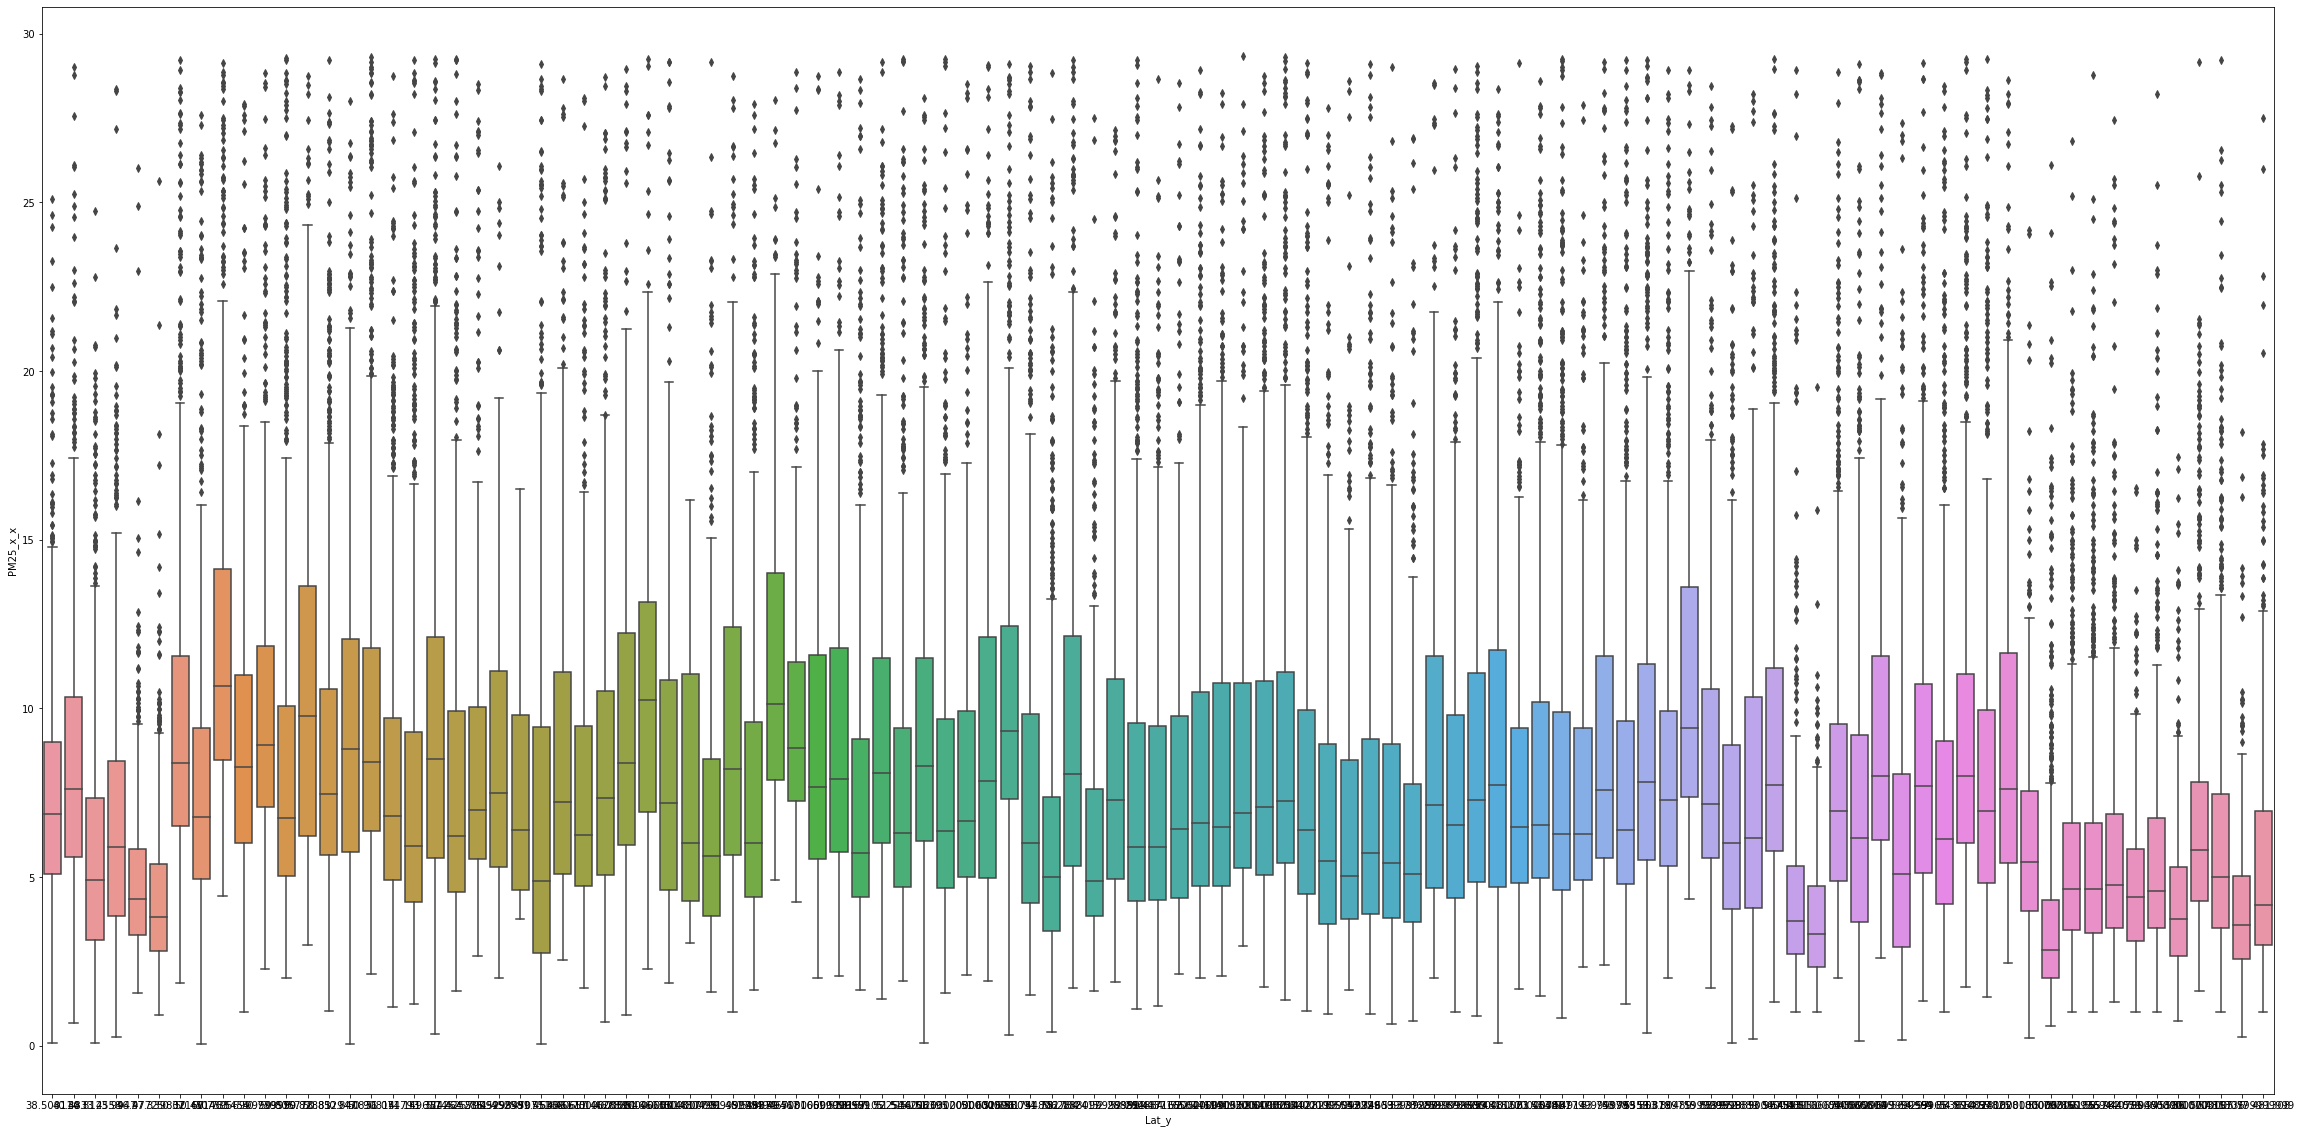

In [5]:
plt. figure(figsize=(40,20))
sns.boxplot(x="Lat_y", y="PM25_x_x", data=all_of_it_2)

In [6]:
plt. figure(figsize=(10,5))
# sns.boxplot(x="Lat", y="0_NO2_column_number_density", data=all_of_it_2)

ValueError: Could not interpret input 'Lat'

<Figure size 720x360 with 0 Axes>

In [7]:
#remove outliers
all_of_it_2 = all_of_it_2[all_of_it_2['0_NO2_column_number_density'] > 0.0]

In [8]:
plt. figure(figsize=(10,5))
sns.boxplot(x="Lat", y='0_tropospheric_NO2_column_number_density', data=all_of_it_2)

ValueError: Could not interpret input 'Lat'

<Figure size 720x360 with 0 Axes>

In [102]:
#remove outliers
all_of_it_2 = all_of_it_2[all_of_it_2['0_tropospheric_NO2_column_number_density'] < 0.000175]

<AxesSubplot:xlabel='Lat', ylabel='0_stratospheric_NO2_column_number_density'>

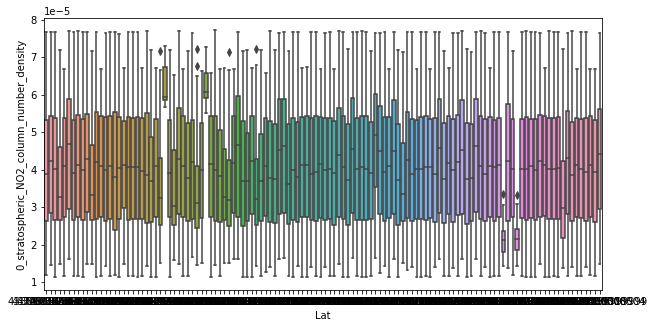

In [104]:
plt. figure(figsize=(10,5))
sns.boxplot(x="Lat", y='0_stratospheric_NO2_column_number_density', data=all_of_it_2)

In [72]:
all_of_it_3 = all_of_it_2.drop(['Lat_y', 'Long_y','pop_density2010_mean'], axis = 1)

In [77]:
all_of_it_3.shape

(61064, 24)

In [74]:
all_of_it_3 = all_of_it_3.rename(columns={'NDVI_8000_mean': 'NDVI', 'QA_8000_mean': 'QA', 'elevation_2000_mean': 'Elev',
       'avg_vis_mean': 'Avg Vis', 'cf_cvg_mean': 'CF', 'precipitable_water_entire_atmosphere': 'Precipitable Water',
       'relative_humidity_2m_above_ground': 'RH',
       'specific_humidity_2m_above_ground': 'SH', 'temperature_2m_above_ground': 'Temp',
       'u_component_of_wind_10m_above_ground': ' U Velocity',
       'v_component_of_wind_10m_above_ground': 'V Velocity', '0_NO2_column_number_density': ' NO2_column',
       '0_NO2_slant_column_number_density': 'NO2_slant',
       '0_stratospheric_NO2_column_number_density': 'NO2_strat', '0_tropopause_pressure': 'Pressure',
       '0_tropospheric_NO2_column_number_density': 'NO2_trop',
       '1_O3_column_number_density': 'O3', '2_CO_column_number_density': 'CO',
       '2_H2O_column_number_density': 'H2O', '2_cloud_height': 'Cloud_height',
       '3_absorbing_aerosol_index': 'Aerosol', 'PM25_x_x':'PM25'})

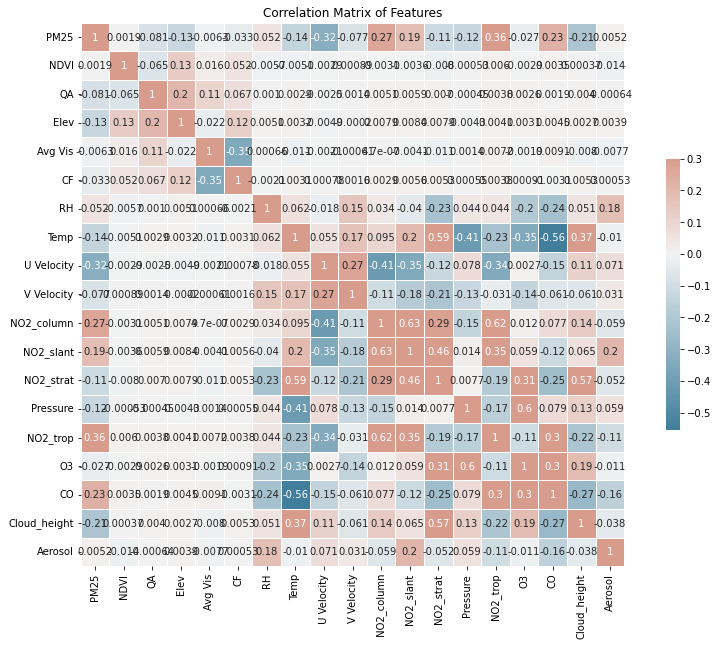

In [81]:
#create a correlation matrix

corr = all_of_it_4.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap = cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Correlation Matrix of Features');
plt.savefig('Correlation Matrix of Features.png',bbox_inches = 'tight')

#annot=True

In [80]:
all_of_it_4 = all_of_it_3.drop(['Precipitable Water', 'H2O', 'SH'], axis = 1)

In [83]:
all_of_it_5 = all_of_it_4.copy().dropna()
all_of_it_5.columns

Index(['location', 'Date', 'PM25', 'NDVI', 'QA', 'Elev', 'Avg Vis', 'CF', 'RH',
       'Temp', ' U Velocity', 'V Velocity', ' NO2_column', 'NO2_slant',
       'NO2_strat', 'Pressure', 'NO2_trop', 'O3', 'CO', 'Cloud_height',
       'Aerosol'],
      dtype='object')

In [84]:
frame = all_of_it_5.copy()

In [86]:
y = frame.pop('PM25').to_frame()
X = frame.drop(['location', 'Date'], axis = 1)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [88]:
X_train.shape

(32503, 18)

In [89]:
X_test.shape

(8126, 18)

In [90]:
rf = RandomForestRegressor(n_estimators = 100, random_state= 42)
rf.fit(X_train, y_train)

C:\Users\Zenudeen\AppData\Local\Temp/ipykernel_3888/2721239124.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [91]:
rf_pred = rf.predict(X_test)

In [92]:
mse = mean_squared_error(y_test, rf_pred)
mse

9.416379200631367

In [93]:
rmse = mse**(1/2)
rmse

3.0686119338605473

In [94]:
print('Score on train data: {}\n'.format(rf.score(X_train, y_train.values.ravel())))
print('Best parameters found:')

Score on train data: 0.9531231632743086

Best parameters found:


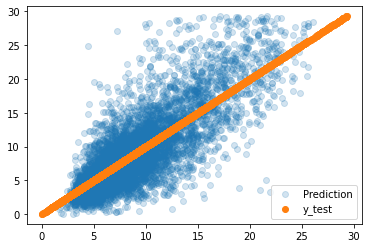

In [95]:
# plot lines
plt.scatter(rf_pred, y_test, label = "Prediction", alpha = 0.2)
plt.scatter(y_test, y_test, label = "y_test")
plt.legend()
plt.show()